In [19]:
# Facultatif: pour mettre votre notebook en pleine largeur écran:
from IPython.core.display import HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline
from sklearn.datasets import load_breast_cancer
from torch import nn, optim
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [20]:
# Get data from Scikit learn
data = load_breast_cancer()
list(data.target_names)

['malignant', 'benign']

In [21]:
# Rename train and target data
data_train = data.data
data_target = data.target

In [4]:
# Create Arguments class with many parameters to be used 
class Arguments():
    def __init__(self):
        self.batch_size = 32
        self.test_batch_size = 32
        self.epochs = 100
        self.lr = 0.01
        self.momentum = 0.5
        self.no_cuda = False
        self.seed = 1
        self.save_model = False

args = Arguments()

use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [5]:
# Split data between train and test 80% train, 20% validation, 20% test.
x_train, x_test, y_train, y_test = train_test_split(data_train, data_target, test_size=0.2, random_state=args.seed)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=args.seed)

# Standardise data for input into Neural Net
scaler = StandardScaler()
transformed = scaler.fit_transform(x_train)
transformed_val = scaler.transform(x_val)
transformed_test = scaler.transform(x_test)

##TRAIN##
# Create a TensorDataset with features and target data
data_train = data_utils.TensorDataset(torch.tensor(transformed, requires_grad= True).float(),
                                 torch.tensor(y_train).float())
# Create a DataLoader to add minibatch and shuffle parameters
train_loader = torch.utils.data.DataLoader(
    data_train,
    batch_size=args.batch_size, shuffle=True, **kwargs)

##VAL##
# Create val DataLoader
data_val = data_utils.TensorDataset(torch.tensor(transformed_val).float(),
                                 torch.tensor(y_val).float())
# Create a DataLoader to add minibatch and shuffle parameters
val_loader = torch.utils.data.DataLoader(
    data_val,
    batch_size=args.test_batch_size, shuffle=False, **kwargs)

##TEST##
# Create test DataLoader
data_test = data_utils.TensorDataset(torch.tensor(transformed_test).float(),
                                 torch.tensor(y_test).float())
# Create a DataLoader to add minibatch and shuffle parameters
test_loader = torch.utils.data.DataLoader(
    data_test,
    batch_size=args.test_batch_size, shuffle=False, **kwargs)

In [6]:
# Layer Noise to help generalise and reduce speed of learning for our use case. 
##### Currently not supported by the federal learning so NOT use into our Net #####
class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
        is_relative_detach (bool, optional): whether to detach the variable before
            computing the scale of the noise. If `False` then the scale of the noise
            won't be seen as a constant but something to optimize: this will bias the
            network to generate vectors with smaller values.
    """

    def __init__(self, sigma=5, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        self.noise = torch.tensor(0).to(device)

    def forward(self, x):
        if self.training and self.sigma != 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = self.noise.repeat(*x.size()).float().normal_() * scale
            x = x + sampled_noise
        return x 

In [22]:
class NetModel(nn.Module):

    def __init__(self, input_dim, output_dim):

        super(NetModel, self).__init__() 
        # Calling Super Class's constructor
        self.linear1 = nn.Linear(input_dim, 30)
        self.linear2 = nn.Linear(30, 30)
        self.linear3 = nn.Linear(30, 30)
        self.linear4 = nn.Linear(30, 1)
        self.sigmoid1 = nn.Sigmoid()
        self.relu1 = nn.ReLU()
        self.noise = GaussianNoise()
        
    def forward(self, x):
        # Here the forward pass is simply a linear function
        x = F.relu(self.linear1(x))
        #if self.training:
        #    x = self.noise(x)
        x = F.relu(self.linear2(x))
        #if self.training:
            #x = self.noise(x)
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        out = self.sigmoid1(x)
        return out

# takes in a module and applies the specified weight initialization
def weights_init_uniform(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

input_dim = 30
output_dim = 1

model = NetModel(input_dim,output_dim)
model.apply(weights_init_uniform)

criterion = nn.BCELoss()# Binary Loss
optimiser = torch.optim.SGD(model.parameters(), lr = args.lr) #Stochastic Gradient Descent

epochs = args.epochs

In [23]:
%%time
history = { "loss": [], "accuracy": [], "loss_val": [], "accuracy_val": [] }

for epoch in range(epochs):

    epoch +=1
    correct = 0
    model_loss_epoch = 0
    for batch_idx, (minibatch, data_target) in enumerate(train_loader):
        # Train Model
        optimiser.zero_grad()
        model_pred = model(minibatch)
        prediction = [1 if x > 0.5 else 0 for x in model_pred.data.numpy()]
        correct += (prediction == data_target.numpy()).sum()
        
        
        model_loss = criterion(model_pred, data_target)
        model_loss.backward()

        optimiser.step()
        model_loss_epoch += model_loss.data
           
    
    history["loss"].append(model_loss_epoch/len(train_loader.dataset)*100)        
    history["accuracy"].append(correct / len(train_loader.dataset)*100)
    model.eval()
    model_loss_val = 0
    correct_val = 0
    with torch.no_grad():
        for batch_idx1, (minibatch_val, data_target_val) in enumerate(val_loader):
            # Validation test 
            model_pred = model(minibatch_val)
            prediction = [1 if x > 0.5 else 0 for x in model_pred.data.numpy()]
            correct_val += (prediction == data_target_val.numpy()).sum()
            model_loss_val += criterion(model_pred, data_target_val)


    history["loss_val"].append(model_loss_val/len(val_loader.dataset)*100)        
    history["accuracy_val"].append(correct_val / len(val_loader.dataset)*100)
    print("Loss, accuracy, val loss, val acc at epoch", epoch ,history["loss"][-1], 
          history["accuracy"][-1], history["loss_val"][-1], 
          history["accuracy_val"][-1] )

Loss, accuracy, val loss, val acc at epoch 1 tensor(2.2822) 52.74725274725275 tensor(2.4309) 59.64912280701754
Loss, accuracy, val loss, val acc at epoch 2 tensor(2.2723) 67.6923076923077 tensor(2.4211) 61.40350877192983
Loss, accuracy, val loss, val acc at epoch 3 tensor(2.2568) 66.15384615384615 tensor(2.4137) 54.385964912280706
Loss, accuracy, val loss, val acc at epoch 4 tensor(2.2449) 64.3956043956044 tensor(2.4070) 54.385964912280706
Loss, accuracy, val loss, val acc at epoch 5 tensor(2.2294) 64.17582417582418 tensor(2.4002) 54.385964912280706
Loss, accuracy, val loss, val acc at epoch 6 tensor(2.2263) 63.73626373626373 tensor(2.3933) 54.385964912280706
Loss, accuracy, val loss, val acc at epoch 7 tensor(2.2090) 63.73626373626373 tensor(2.3864) 54.385964912280706
Loss, accuracy, val loss, val acc at epoch 8 tensor(2.1982) 63.73626373626373 tensor(2.3789) 56.14035087719298
Loss, accuracy, val loss, val acc at epoch 9 tensor(2.1929) 64.17582417582418 tensor(2.3719) 56.1403508771929

Loss, accuracy, val loss, val acc at epoch 81 tensor(1.0633) 94.06593406593406 tensor(1.5064) 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 82 tensor(1.0814) 93.84615384615384 tensor(1.5039) 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 83 tensor(1.1004) 94.28571428571428 tensor(1.5004) 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 84 tensor(1.0585) 94.5054945054945 tensor(1.4979) 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 85 tensor(1.0510) 94.72527472527472 tensor(1.4959) 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 86 tensor(1.0217) 94.72527472527472 tensor(1.4934) 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 87 tensor(1.0306) 94.72527472527472 tensor(1.4914) 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 88 tensor(1.0116) 94.72527472527472 tensor(1.4882) 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 89 tensor(1.0429) 94.94505494505493 tensor(1.4872) 96.49122807

In [24]:
correct = 0
for batch_idx, (minibatch, data_target) in enumerate(test_loader):
    # Train minibach
    optimiser.zero_grad()
    model_pred = model(minibatch)
    prediction = [1 if x > 0.5 else 0 for x in model_pred.data.numpy()]
    correct += (prediction == data_target.numpy()).sum()
    
print(correct/len(test_loader.dataset)*100)


94.73684210526315


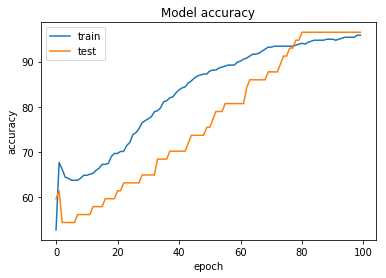

In [25]:
plt.plot(history['accuracy'])
plt.plot(history['accuracy_val'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

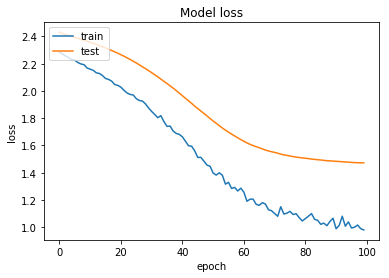

In [26]:
plt.plot(history['loss'])
plt.plot(history['loss_val'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()